In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA = Path("../data/processed/ethiopia_fi_unified_data_enriched.xlsx")

df = pd.read_excel(DATA)


In [8]:
date_cols = [
    "observation_date",
    "period_start",
    "period_end",
    "collection_date"
]

for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


In [9]:
observations = df[df["record_type"] == "observation"].copy()
events = df[df["record_type"] == "event"].copy()
impacts = df[df["record_type"] == "impact_link"].copy()

print("Observations:", observations.shape)
print("Events:", events.shape)
print("Impact links:", impacts.shape)


Observations: (31, 35)
Events: (10, 35)
Impact links: (0, 35)


In [10]:
event_lookup = events[[
    "record_id",
    "indicator",
    "indicator_code",
    "observation_date",
    "original_text"
]].rename(columns={
    "indicator": "event_name",
    "indicator_code": "event_code",
    "observation_date": "event_date",
    "original_text": "event_description"
})

impact_model = impacts.merge(
    event_lookup,
    left_on="parent_id",
    right_on="record_id",
    how="left"
)

impact_model.head()


,record_id_x,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,collected_by,collection_date,original_text,notes,parent_id,record_id_y,event_name,event_code,event_date,event_description


In [11]:
# Force numeric
impact_model["impact_magnitude"] = pd.to_numeric(
    impact_model["impact_magnitude"], errors="coerce"
)

impact_model["impact_estimate"] = pd.to_numeric(
    impact_model["impact_estimate"], errors="coerce"
)

# Normalize direction text
impact_model["impact_direction"] = (
    impact_model["impact_direction"]
    .astype(str)
    .str.lower()
    .str.strip()
)

direction_map = {
    "positive": 1,
    "negative": -1,
    "neutral": 0
}

impact_model["direction_num"] = impact_model["impact_direction"].map(direction_map)


In [12]:
impact_model["effect_size"] = (
    impact_model["direction_num"] *
    impact_model["impact_magnitude"].fillna(
        impact_model["impact_estimate"]
    )
)

impact_model[[
    "event_code",
    "indicator_code",
    "impact_direction",
    "impact_magnitude",
    "effect_size"
]].head()


,event_code,indicator_code,impact_direction,impact_magnitude,effect_size


In [13]:
association_matrix = impact_model.pivot_table(
    index="event_code",
    columns="indicator_code",
    values="effect_size",
    aggfunc="mean"
)

association_matrix


indicator_code
event_code


In [16]:
clean_matrix = association_matrix.dropna(how="all", axis=0).dropna(how="all", axis=1)

if clean_matrix.empty:
    print("No valid associations to display.")
else:

    plt.figure(figsize=(14, 8))
    sns.heatmap(
        clean_matrix,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Event → Indicator Impact Matrix")
    plt.tight_layout()
    plt.show()


No valid associations to display.


In [17]:
def simulate_indicator_with_events(
    indicator_code: str,
    observations_df: pd.DataFrame,
    impact_df: pd.DataFrame
):
    base = (
        observations_df[
            observations_df["indicator_code"] == indicator_code
        ]
        .set_index("observation_date")["value_numeric"]
        .sort_index()
    )

    simulated = base.copy()

    relevant_impacts = impact_df[
        impact_df["indicator_code"] == indicator_code
    ]

    for _, row in relevant_impacts.iterrows():
        if pd.isna(row["event_date"]):
            continue

        lag = int(row["lag_months"]) if not pd.isna(row["lag_months"]) else 0
        start_date = row["event_date"] + pd.DateOffset(months=lag)

        simulated.loc[simulated.index >= start_date] += row["effect_size"]

    return base, simulated


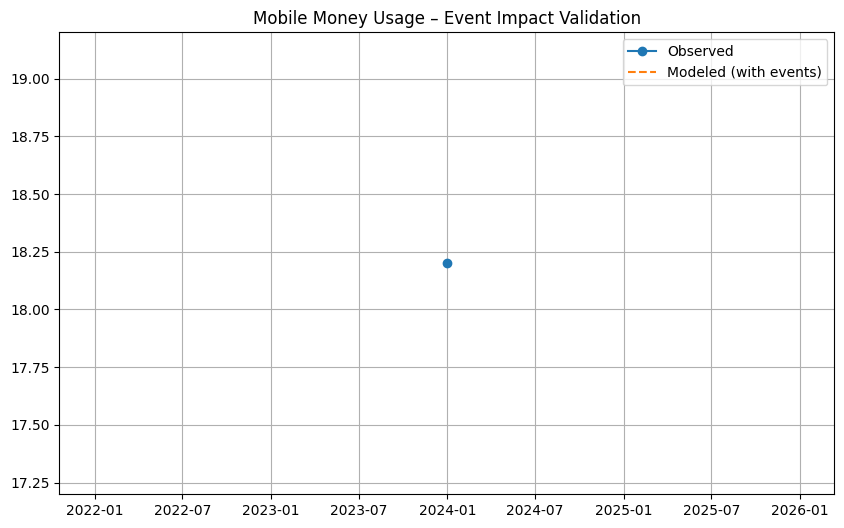

In [18]:
base, sim = simulate_indicator_with_events(
    indicator_code="mm_active_pct",
    observations_df=observations,
    impact_df=impact_model
)

plt.figure(figsize=(10, 6))
plt.plot(base, label="Observed", marker="o")
plt.plot(sim, label="Modeled (with events)", linestyle="--")
plt.legend()
plt.title("Mobile Money Usage – Event Impact Validation")
plt.grid(True)
plt.show()


## Event Impact Modeling Methodology

- Each `impact_link` row represents a causal relationship
- Effect size = direction × magnitude
- Impacts applied after specified lag (months)
- Multiple events combine additively
- Comparable-country evidence used where Ethiopia data sparse

### Limitations
- Linear effects only
- No saturation or adoption ceilings
- No interaction effects between events
